# Import init Package

In [15]:
%matplotlib inline

In [16]:
from numpy import array
from numpy.linalg import pinv
from matplotlib import pyplot

In [22]:
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential 
from keras.callbacks import TensorBoard,EarlyStopping
import numpy as np
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import log_loss
import  seaborn as sns
import matplotlib.pyplot as plt

# example : SVD

#### X = U . Sigma . V^*

[1.00233226]


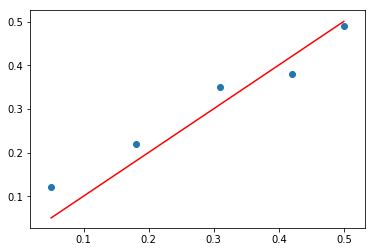

In [17]:
# least squares via SVD with pseudoinverse
data = array([
	[0.05, 0.12],
	[0.18, 0.22],
	[0.31, 0.35],
	[0.42, 0.38],
	[0.5, 0.49],
	])
X, y = data[:,0], data[:,1]
X = X.reshape((len(X), 1))
# calculate coefficients  # PINV 求解廣義的逆矩陣
b = pinv(X).dot(y)
print(b)
# predict using coefficients
yhat = X.dot(b)
# plot data and predictions
pyplot.scatter(X, y)
pyplot.plot(X, yhat, color='red')
pyplot.show()

# 1. Import dataset

In [44]:
from sklearn import datasets
import pandas as pd 
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [28]:
diabets = datasets.load_diabetes()

In [34]:
diabets.keys()

dict_keys(['data', 'target', 'DESCR', 'feature_names', 'data_filename', 'target_filename'])

In [72]:
diabets['feature_names']

['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6']

In [73]:
x = pd.DataFrame(diabets['data'],columns = diabets['feature_names'])
y = pd.DataFrame(diabets['target'],columns = ['disease progression']) # Target为一年后患疾病的定量指标。

In [74]:
data = pd.concat([x,y],axis=1)

In [75]:
X = data.drop(['disease progression'], axis=1)
y = data['disease progression']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state= 123)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state= 123)

display(
      X_train.shape,
      X_val.shape,
      X_test.shape,
      y_train.shape,
      y_val.shape,
      y_test.shape,
)

(282, 10)

(71, 10)

(89, 10)

(282,)

(71,)

(89,)

# 2. Using Keras to build model

In [90]:
from keras import backend as K
from keras.layers import Dense
from keras.models import Sequential, Model as keras_models_Model

In [144]:

def FlattenWeights(weights):
        """
        flatten weights
        
        param weights: keras神經網路的權重格式:nparray包在list中
        return WeightsStrucure : 神經網路各層的權重shape包在list中，unflatten時會用到
        return FlattenedWeights : 一維list包含所有的權重
        """
        WeightsStrucure = []
        FlattenedWeights = []
        for i_layer in weights:
            WeightsStrucure.append(i_layer.shape)
            if len(i_layer.shape) == 1 :# 該層權重的shape為一維 e.g. (15,)      
                FlattenedWeights.extend(i_layer)
            else :# 該層權重的shape為二維 e.g. (30, 15)  
                for i_links in i_layer:
                    FlattenedWeights.extend(i_links)
        return WeightsStrucure, FlattenedWeights

def UnflattenWeights(WeightsStrucure, ModifiedWeights):
    """
    Unflatten(回復成原本的結構) weights  

    param WeightsStrucure : 神經網路各層的權重shape包在list中
    param ModifiedWeights : 一維list包含所有meteHeuristic修改過的權重
    return: keras神經網路的權重格式:nparray包在list中
    """
    UnflattenWeights = []
    i_index = 0 
    for i_layer in WeightsStrucure:
        if len(i_layer) == 1 : # 該層權重的shape為一維 e.g. (15,)      
            TempList = ModifiedWeights[i_index:(i_index + i_layer[0])]
            TempList = np.asarray(TempList)
            i_index = i_index + i_layer[0]
        else : # 該層權重的shape為二維 e.g. (30, 15)  
            TempList = ModifiedWeights[i_index:(i_index + (i_layer[0]*i_layer[1]))]
            TempList = np.reshape(TempList, i_layer )
            i_index = i_index + (i_layer[0]*i_layer[1])
        UnflattenWeights.append(TempList)
    return UnflattenWeights    
def ModelCompile():
    K.clear_session() 
    gpu_options = tf.GPUOptions(allow_growth=True)
    sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
    tf.keras.backend.set_session(sess)

    model = Sequential()
    model.add(Dense(10, input_dim=10, kernel_initializer='normal', activation='relu',name = 'IntermediateLayer'))
    model.add(Dense(1, kernel_initializer='normal'))
    # Compile model
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model

def ModelFit(model, weights, epochs):
    #class_weight = {0: 1., 1: 1525/2632}
    model.set_weights(weights)
    modelcallbacks = model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1,
        validation_data = (X_val, y_val),
        callbacks=[EarlyStopping(monitor='val_loss', patience=3, verbose=2, restore_best_weights=True)],
        shuffle=True) #, class_weight=class_weight
#     SummarizeHistory(modelcallbacks, UseValid=True)                                        
    weights = model.get_weights() 
    return model, weights

### 2.1 Build init Model

In [164]:
model = ModelCompile()
weights = model.get_weights() 
model, weights = ModelFit(model=model, weights=weights, epochs=150)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Train on 282 samples, validate on 71 samples
Epoch 1/150
282/282 [==============================] - 0s 463us/step - loss: 28557.8469 - val_loss: 31097.8088
Epoch 2/150
282/282 [==============================] - 0s 71us/step - loss: 28554.5568 - val_loss: 31094.1571
Epoch 3/150
282/282 [==============================] - 0s 67us/step - loss: 28551.0244 - val_loss: 31090.1178
Epoch 4/150
282/282 [==============================] - 0s 71us/step - loss: 28547.0370 - val_loss: 31085.6981
Epoch 5/150
282/282 [==============================] -

282/282 [==============================] - 0s 67us/step - loss: 26430.2428 - val_loss: 28759.1918
Epoch 70/150
282/282 [==============================] - 0s 71us/step - loss: 26367.6849 - val_loss: 28692.0217
Epoch 71/150
282/282 [==============================] - 0s 64us/step - loss: 26304.5031 - val_loss: 28625.0735
Epoch 72/150
282/282 [==============================] - 0s 64us/step - loss: 26242.7336 - val_loss: 28556.0309
Epoch 73/150
282/282 [==============================] - 0s 64us/step - loss: 26178.2738 - val_loss: 28487.1366
Epoch 74/150
282/282 [==============================] - 0s 67us/step - loss: 26113.5272 - val_loss: 28417.8329
Epoch 75/150
282/282 [==============================] - 0s 64us/step - loss: 26049.9670 - val_loss: 28346.3901
Epoch 76/150
282/282 [==============================] - 0s 64us/step - loss: 25983.8260 - val_loss: 28275.2508
Epoch 77/150
282/282 [==============================] - 0s 60us/step - loss: 25918.0534 - val_loss: 28203.1215
Epoch 78/150
2

282/282 [==============================] - 0s 67us/step - loss: 20685.4906 - val_loss: 22507.0308
Epoch 143/150
282/282 [==============================] - 0s 67us/step - loss: 20596.4577 - val_loss: 22408.3209
Epoch 144/150
282/282 [==============================] - 0s 67us/step - loss: 20504.6767 - val_loss: 22311.2393
Epoch 145/150
282/282 [==============================] - 0s 60us/step - loss: 20415.8431 - val_loss: 22212.4951
Epoch 146/150
282/282 [==============================] - 0s 67us/step - loss: 20323.2588 - val_loss: 22116.0328
Epoch 147/150
282/282 [==============================] - 0s 71us/step - loss: 20237.2169 - val_loss: 22014.8780
Epoch 148/150
282/282 [==============================] - 0s 60us/step - loss: 20143.8119 - val_loss: 21916.7949
Epoch 149/150
282/282 [==============================] - 0s 64us/step - loss: 20053.2746 - val_loss: 21818.6528
Epoch 150/150
282/282 [==============================] - 0s 60us/step - loss: 19964.4797 - val_loss: 21718.6268


In [166]:
yhat = model.predict(X_train)
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train, yhat)

19911.485629880808

###  2.2 Using Linear Reg to minimize error

In [184]:
layer_name = 'IntermediateLayer'

In [167]:
structure, flat_weight = FlattenWeights(weights)
UnflattenedWeights = UnflattenWeights(structure, flat_weight )
model.set_weights(UnflattenedWeights)
intermediate_layer_model = keras_models_Model(inputs=model.input,
                                              outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X_train)

from sklearn.linear_model import LinearRegression
lm = LinearRegression().fit(intermediate_output, y_train)

#get OutLayerWeights
OutLayerWeights = [np.array(lm.coef_).reshape(structure[-2]),
                   np.array(lm.intercept_).reshape(structure[-1])]

#update ES-optimized weights
UnflattenedWeights[-2:] = OutLayerWeights        

model.set_weights(UnflattenedWeights)

In [169]:
yhat = model.predict(X_train)
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train, yhat)

3077.8420727330704

# 3. Use SVD implement reg

### 3.1 Build init Model

In [176]:
model = ModelCompile()
weights = model.get_weights() 
model, weights = ModelFit(model=model, weights=weights, epochs=150)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
IntermediateLayer (Dense)    (None, 10)                110       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 121
Trainable params: 121
Non-trainable params: 0
_________________________________________________________________
Train on 282 samples, validate on 71 samples
Epoch 1/150
282/282 [==============================] - 0s 453us/step - loss: 28557.6877 - val_loss: 31097.5228
Epoch 2/150
282/282 [==============================] - 0s 67us/step - loss: 28554.0464 - val_loss: 31093.3045
Epoch 3/150
282/282 [==============================] - 0s 71us/step - loss: 28549.8590 - val_loss: 31088.5069
Epoch 4/150
282/282 [==============================] - 0s 67us/step - loss: 28545.1677 - val_loss: 31083.0814
Epoch 5/150
282/282 [==============================] -

282/282 [==============================] - 0s 71us/step - loss: 26594.8848 - val_loss: 28946.9692
Epoch 70/150
282/282 [==============================] - 0s 67us/step - loss: 26543.3001 - val_loss: 28888.7843
Epoch 71/150
282/282 [==============================] - 0s 67us/step - loss: 26489.4501 - val_loss: 28830.3468
Epoch 72/150
282/282 [==============================] - 0s 64us/step - loss: 26434.6043 - val_loss: 28771.9469
Epoch 73/150
282/282 [==============================] - 0s 64us/step - loss: 26380.9890 - val_loss: 28711.8840
Epoch 74/150
282/282 [==============================] - 0s 64us/step - loss: 26324.7972 - val_loss: 28652.1169
Epoch 75/150
282/282 [==============================] - 0s 64us/step - loss: 26269.2832 - val_loss: 28591.4620
Epoch 76/150
282/282 [==============================] - 0s 64us/step - loss: 26212.8580 - val_loss: 28530.3071
Epoch 77/150
282/282 [==============================] - 0s 71us/step - loss: 26156.7186 - val_loss: 28467.8075
Epoch 78/150
2

282/282 [==============================] - 0s 64us/step - loss: 21570.8666 - val_loss: 23478.0176
Epoch 143/150
282/282 [==============================] - 0s 60us/step - loss: 21491.5143 - val_loss: 23390.9664
Epoch 144/150
282/282 [==============================] - 0s 60us/step - loss: 21411.7158 - val_loss: 23303.1773
Epoch 145/150
282/282 [==============================] - 0s 60us/step - loss: 21330.7730 - val_loss: 23215.7073
Epoch 146/150
282/282 [==============================] - 0s 60us/step - loss: 21250.6548 - val_loss: 23127.5716
Epoch 147/150
282/282 [==============================] - 0s 64us/step - loss: 21169.7121 - val_loss: 23039.6424
Epoch 148/150
282/282 [==============================] - 0s 60us/step - loss: 21088.2748 - val_loss: 22952.0281
Epoch 149/150
282/282 [==============================] - 0s 64us/step - loss: 21007.6291 - val_loss: 22863.9912
Epoch 150/150
282/282 [==============================] - 0s 60us/step - loss: 20926.7363 - val_loss: 22775.1602


In [177]:
yhat = model.predict(X_train)
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train, yhat)

20880.279718377893

### 3.2 get intermediate layer

In [178]:
# structure, flat_weight = FlattenWeights(weights)
# UnflattenedWeights = UnflattenWeights(structure, flat_weight)
model.set_weights(weights)
intermediate_layer_model = keras_models_Model(inputs=model.input,
                                              outputs=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X_train)

In [180]:
reg_input = intermediate_output.reshape((len(intermediate_output), 10))
# calculate coefficients  # PINV 求解廣義的逆矩陣
b = pinv(reg_input).dot(y_train)
print(b)

[ 1.42845354e+03 -4.68229802e-12 -5.11380062e+02  1.18202121e+03
 -2.77329467e+03 -1.15271089e+03  1.71856210e+03  0.00000000e+00
  0.00000000e+00  0.00000000e+00]


In [181]:
yhat = reg_input.dot(b)

In [182]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_train, yhat)

3444.7100015676383